## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


### Generally
- Never trust the data blindly

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11401468844628704544
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2848473088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13502729934657619456
physical_device_desc: "device: 0, name: GeForce GTX 780M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


### Constants

In [31]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False
NUM_KEYPOINTS = 30
IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )

### Load the Data

In [18]:
def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    if not test:
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
    else:
        Y = None
        
    # remove rows having bad images or labels
    X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
    Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
    
    # normalize - by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)
    
    # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
    X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
    X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
    Y_model1 = np.zeros( Y.shape, dtype=float)
    Y_model2 = np.zeros( Y.shape, dtype=float)
    tempIdx1 = 0
    tempIdx2 = 0
    
    for thisIdx in range(0, Y.shape[0]):
        numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
        
        if( ( numKeyps > 8 ) ):
            X_model1[tempIdx1] = X[thisIdx,:,:]
            Y_model1[tempIdx1] = Y[thisIdx,:]
            tempIdx1 = tempIdx1 + 1
        else:
            X_model2[tempIdx2] = X[thisIdx,:,:]
            Y_model2[tempIdx2] = Y[thisIdx,:]
            tempIdx2 = tempIdx2 + 1

    # remove empty rows
    drop_idx1 = []
    drop_idx2 = []
    
    for idx in range(0, X.shape[0]):
        if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
            drop_idx1.append(idx)
        if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
            drop_idx2.append(idx)
    
    X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
    Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
    X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
    Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
    
    # remove empty columns, setup lists of labels
    labels = df.columns.difference(['Image'])
    labels1 = labels
    labels2 = []
    drop_idx3 = []
    for idx in range(0, Y.shape[1]):
        if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
            drop_idx3.append(idx)
        else:
            labels2.append(labels[idx])
    Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
    
    # return the original dataset and the group splits
    return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels


In [19]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [23]:
print("Model1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Model2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Model1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Model2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images

In [21]:
# function to plot an image
def plot_image(image, points, labels=list(labels), title=None):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'m*')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [ ]:
# checking some images from both groups
print("\n Train dataset:")
plot_image(X[1626], 48*Y[1626]+48, labels)
plot_image(X[1627], 48*Y[1627]+48, labels)
plot_image(X[1628], 48*Y[1628]+48, labels)
plot_image(X[1629], 48*Y[1629]+48, labels)

print("\n Model1 dataset:")
plot_image(X1[1626], 48*Y1[1626]+48, labels1)
plot_image(X1[1627], 48*Y1[1627]+48, labels1)
plot_image(X1[1628], 48*Y1[1628]+48, labels1)
plot_image(X1[1629], 48*Y1[1629]+48, labels1)

print("\n Model2 dataset:")
plot_image(X2[0], 48*Y2[0]+48, labels2)
plot_image(X2[1], 48*Y2[1]+48, labels2)
plot_image(X2[2], 48*Y2[2]+48, labels2)
plot_image(X2[3], 48*Y2[3]+48, labels2)


### Model Fitting Function

In [32]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000):
    if retrain or not os.path.exists('../saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=Nadam())
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat
                     )
        model.save('../saved-models/'+ modelname + '.h5')
        with open('../saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('../saved-models/'+modelname+'.h5')
        history = pickle.load(open( "../saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [25]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models for group1 dataset (images with more than 8 keypoints)
### 1 Dense Hidden Layer with 100 units

In [36]:
g1_model1 = Sequential()
g1_model1.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1.add(Dense(100, activation='relu'))
g1_model1.add(Dense(30))
print(g1_model1.summary())
g1_model1_hist, g1_model1 = fit_model(g1_model1, data1, 'g1_1dense100neuronlayer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               921700    
_________________________________________________________________
dense_14 (Dense)             (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
10000
Train on 1709 samples, validate on 428 samples
Epoch 1/10000
1709/1709 [==============================] - 1s 448us/step - loss: 9.0740 - val_loss: 0.9377
Epoch 2/10000
1709/1709 [==============================] - 0s 285us/step - loss: 21.6629 - val_loss: 3.2093
Epoch 3/10000
1709/1709 [==============================] - 0s 292us/step - loss: 1.4428 - val_loss: 1.3366
Epoch 4/10000
1709/1

1709/1709 [==============================] - 0s 273us/step - loss: 0.0435 - val_loss: 0.0854
Epoch 70/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0492 - val_loss: 0.0491
Epoch 71/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0416 - val_loss: 0.0646
Epoch 72/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0506 - val_loss: 0.0750
Epoch 73/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0419 - val_loss: 0.0666
Epoch 74/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0375 - val_loss: 0.0547
Epoch 75/10000
1709/1709 [==============================] - 0s 272us/step - loss: 102.9080 - val_loss: 29.8408
Epoch 76/10000
1709/1709 [==============================] - 0s 269us/step - loss: 6.4214 - val_loss: 1.8584
Epoch 77/10000
1709/1709 [==============================] - 0s 278us/step - loss: 1.0391 - val_loss: 0.8941
Epoch 78/10000
1709/1709 [==============

1709/1709 [==============================] - 0s 278us/step - loss: 0.0360 - val_loss: 0.1031
Epoch 145/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0425 - val_loss: 0.1118
Epoch 146/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0431 - val_loss: 0.1769
Epoch 147/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0577 - val_loss: 0.1299
Epoch 148/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0704 - val_loss: 0.1117
Epoch 149/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0547 - val_loss: 0.1234
Epoch 150/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0654 - val_loss: 0.1456
Epoch 151/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.1039 - val_loss: 0.1439
Epoch 152/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0954 - val_loss: 0.1579
Epoch 153/10000
1709/1709 [========

1709/1709 [==============================] - 1s 300us/step - loss: 0.0083 - val_loss: 0.0214
Epoch 220/10000
1709/1709 [==============================] - 1s 299us/step - loss: 0.0080 - val_loss: 0.0207
Epoch 221/10000
1709/1709 [==============================] - 1s 313us/step - loss: 0.0079 - val_loss: 0.0219
Epoch 222/10000
1709/1709 [==============================] - 1s 354us/step - loss: 0.0078 - val_loss: 0.0228
Epoch 223/10000
1709/1709 [==============================] - 1s 351us/step - loss: 0.0073 - val_loss: 0.0225
Epoch 224/10000
1709/1709 [==============================] - 1s 391us/step - loss: 0.0062 - val_loss: 0.0190
Epoch 225/10000
1709/1709 [==============================] - 1s 466us/step - loss: 0.0056 - val_loss: 0.0176
Epoch 226/10000
1709/1709 [==============================] - 1s 403us/step - loss: 0.0055 - val_loss: 0.0236
Epoch 227/10000
1709/1709 [==============================] - 1s 607us/step - loss: 0.0082 - val_loss: 0.0208
Epoch 228/10000
1709/1709 [========

1709/1709 [==============================] - 1s 313us/step - loss: 0.0199 - val_loss: 0.0368
Epoch 295/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0174 - val_loss: 0.0345
Epoch 296/10000
1709/1709 [==============================] - 1s 365us/step - loss: 0.0158 - val_loss: 0.0325
Epoch 297/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0144 - val_loss: 0.0300
Epoch 298/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0128 - val_loss: 0.0287
Epoch 299/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0118 - val_loss: 0.0272
Epoch 300/10000
1709/1709 [==============================] - ETA: 0s - loss: 0.010 - 1s 317us/step - loss: 0.0108 - val_loss: 0.0260
Epoch 301/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0105 - val_loss: 0.0260
Epoch 302/10000
1709/1709 [==============================] - 1s 325us/step - loss: 0.0094 - val_loss: 0.0246
Epoch 303/1

1709/1709 [==============================] - 1s 337us/step - loss: 0.0027 - val_loss: 0.0054
Epoch 370/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0031 - val_loss: 0.0075
Epoch 371/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0031 - val_loss: 0.0058
Epoch 372/10000
1709/1709 [==============================] - 1s 319us/step - loss: 0.0031 - val_loss: 0.0260
Epoch 373/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0084 - val_loss: 0.0056
Epoch 374/10000
1709/1709 [==============================] - 1s 322us/step - loss: 0.0033 - val_loss: 0.0076
Epoch 375/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0106 - val_loss: 0.0057
Epoch 376/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0035 - val_loss: 0.0054
Epoch 377/10000
1709/1709 [==============================] - 1s 302us/step - loss: 0.0029 - val_loss: 0.0068
Epoch 378/10000
1709/1709 [========

1709/1709 [==============================] - 0s 279us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 445/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0019 - val_loss: 0.0035
Epoch 446/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0017 - val_loss: 0.0041
Epoch 447/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0016 - val_loss: 0.0060
Epoch 448/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0023 - val_loss: 0.0038
Epoch 449/10000
1709/1709 [==============================] - 1s 303us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 450/10000
1709/1709 [==============================] - 1s 295us/step - loss: 0.0014 - val_loss: 0.0033
Epoch 451/10000
1709/1709 [==============================] - 1s 299us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 452/10000
1709/1709 [==============================] - 0s 284us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 453/10000
1709/1709 [========

1709/1709 [==============================] - 1s 323us/step - loss: 0.0064 - val_loss: 0.0104
Epoch 520/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0056 - val_loss: 0.0106
Epoch 521/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0053 - val_loss: 0.0117
Epoch 522/10000
1709/1709 [==============================] - 1s 298us/step - loss: 0.0051 - val_loss: 0.0086
Epoch 523/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0052 - val_loss: 0.0089
Epoch 524/10000
1709/1709 [==============================] - 1s 301us/step - loss: 0.0051 - val_loss: 0.0095
Epoch 525/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 526/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0044 - val_loss: 0.0085
Epoch 527/10000
1709/1709 [==============================] - 1s 317us/step - loss: 0.0041 - val_loss: 0.0086
Epoch 528/10000
1709/1709 [========

1709/1709 [==============================] - 0s 282us/step - loss: 0.0050 - val_loss: 0.0131
Epoch 595/10000
1709/1709 [==============================] - 0s 265us/step - loss: 0.0056 - val_loss: 0.0073
Epoch 596/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0033 - val_loss: 0.0074
Epoch 597/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 598/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0035 - val_loss: 0.0059
Epoch 599/10000
1709/1709 [==============================] - 0s 266us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 600/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0042 - val_loss: 0.0229
Epoch 601/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0085 - val_loss: 0.0058
Epoch 602/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0041 - val_loss: 0.0047
Epoch 603/10000
1709/1709 [========

1709/1709 [==============================] - 0s 273us/step - loss: 0.0013 - val_loss: 0.0037
Epoch 670/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0013 - val_loss: 0.0038
Epoch 671/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0014 - val_loss: 0.0052
Epoch 672/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0018 - val_loss: 0.0046
Epoch 673/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0026 - val_loss: 0.0064
Epoch 674/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0017 - val_loss: 0.0038
Epoch 675/10000
1709/1709 [==============================] - 0s 285us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 676/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0013 - val_loss: 0.0097
Epoch 677/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 678/10000
1709/1709 [========

1709/1709 [==============================] - 0s 266us/step - loss: 0.0112 - val_loss: 0.0200
Epoch 744/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0102 - val_loss: 0.0209
Epoch 745/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0095 - val_loss: 0.0196
Epoch 746/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0087 - val_loss: 0.0174
Epoch 747/10000
1709/1709 [==============================] - 0s 267us/step - loss: 0.0081 - val_loss: 0.0176
Epoch 748/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0077 - val_loss: 0.0173
Epoch 749/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0074 - val_loss: 0.0168
Epoch 750/10000
1709/1709 [==============================] - 0s 267us/step - loss: 0.0070 - val_loss: 0.0152
Epoch 751/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0067 - val_loss: 0.0193
Epoch 752/10000
1709/1709 [========

1709/1709 [==============================] - 0s 268us/step - loss: 0.0049 - val_loss: 0.0056
Epoch 819/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0060 - val_loss: 0.0076
Epoch 820/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0045 - val_loss: 0.0065
Epoch 821/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0116 - val_loss: 0.0125
Epoch 822/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0065 - val_loss: 0.0055
Epoch 823/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0049 - val_loss: 0.0057
Epoch 824/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0038 - val_loss: 0.0523
Epoch 825/10000
1709/1709 [==============================] - 0s 266us/step - loss: 0.0065 - val_loss: 0.0054
Epoch 826/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0041 - val_loss: 0.0070
Epoch 827/10000
1709/1709 [========

1709/1709 [==============================] - 0s 274us/step - loss: 0.0015 - val_loss: 0.0038
Epoch 894/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0015 - val_loss: 0.0035
Epoch 895/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0014 - val_loss: 0.0043
Epoch 896/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0014 - val_loss: 0.0041
Epoch 897/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 898/10000
1709/1709 [==============================] - 0s 281us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 899/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0014 - val_loss: 0.0038
Epoch 900/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0014 - val_loss: 0.0080
Epoch 901/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0017 - val_loss: 0.0089
Epoch 902/10000
1709/1709 [========

Epoch 968/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0010 - val_loss: 0.0044
Epoch 969/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 970/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0050
Epoch 971/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 972/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 973/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0010 - val_loss: 0.0060
Epoch 974/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0011 - val_loss: 0.0057
Epoch 975/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0012 - val_loss: 0.0049
Epoch 976/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0014 - val_loss: 0.0057
Epoch 977/10000
170

1709/1709 [==============================] - 0s 268us/step - loss: 0.0060 - val_loss: 0.0069
Epoch 1043/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0041 - val_loss: 0.0250
Epoch 1044/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0133 - val_loss: 0.0052
Epoch 1045/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0036 - val_loss: 0.0056
Epoch 1046/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0154 - val_loss: 0.0084
Epoch 1047/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 1048/10000
1709/1709 [==============================] - 0s 264us/step - loss: 0.0046 - val_loss: 0.0044
Epoch 1049/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0037 - val_loss: 0.0046
Epoch 1050/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0034 - val_loss: 0.0059
Epoch 1051/10000
1709/1709 

1709/1709 [==============================] - 0s 271us/step - loss: 0.0026 - val_loss: 0.0056
Epoch 1117/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0028 - val_loss: 0.0052
Epoch 1118/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0025 - val_loss: 0.0120
Epoch 1119/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1120/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 1121/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0033 - val_loss: 0.0049
Epoch 1122/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0025 - val_loss: 0.0058
Epoch 1123/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 1124/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 1125/10000
1709/1709 

1709/1709 [==============================] - 0s 279us/step - loss: 0.0011 - val_loss: 0.0043
Epoch 1191/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0010 - val_loss: 0.0046
Epoch 1192/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0011 - val_loss: 0.0041
Epoch 1193/10000
1709/1709 [==============================] - 0s 271us/step - loss: 9.8112e-04 - val_loss: 0.0045
Epoch 1194/10000
1709/1709 [==============================] - 0s 262us/step - loss: 9.7015e-04 - val_loss: 0.0040
Epoch 1195/10000
1709/1709 [==============================] - 0s 280us/step - loss: 9.3093e-04 - val_loss: 0.0040
Epoch 1196/10000
1709/1709 [==============================] - 0s 275us/step - loss: 9.2976e-04 - val_loss: 0.0041
Epoch 1197/10000
1709/1709 [==============================] - 0s 277us/step - loss: 9.4023e-04 - val_loss: 0.0049
Epoch 1198/10000
1709/1709 [==============================] - 0s 276us/step - loss: 9.4378e-04 - val_loss: 0.0042
Epo

1709/1709 [==============================] - 1s 296us/step - loss: 0.0062 - val_loss: 0.0278
Epoch 1265/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0059 - val_loss: 0.0263
Epoch 1266/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0056 - val_loss: 0.0309
Epoch 1267/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0053 - val_loss: 0.0259
Epoch 1268/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0054 - val_loss: 0.0264
Epoch 1269/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0051 - val_loss: 0.0273
Epoch 1270/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0051 - val_loss: 0.0254
Epoch 1271/10000
1709/1709 [==============================] - 0s 287us/step - loss: 0.0052 - val_loss: 0.0354
Epoch 1272/10000
1709/1709 [==============================] - 0s 284us/step - loss: 0.0051 - val_loss: 0.0258
Epoch 1273/10000
1709/1709 

1709/1709 [==============================] - 0s 283us/step - loss: 0.0024 - val_loss: 0.0067
Epoch 1339/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0030 - val_loss: 0.0088
Epoch 1340/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0026 - val_loss: 0.0062
Epoch 1341/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0027 - val_loss: 0.0062
Epoch 1342/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0031 - val_loss: 0.0071
Epoch 1343/10000
1709/1709 [==============================] - 0s 265us/step - loss: 0.0027 - val_loss: 0.0060
Epoch 1344/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 1345/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0026 - val_loss: 0.0057
Epoch 1346/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0024 - val_loss: 0.0068
Epoch 1347/10000
1709/1709 

1709/1709 [==============================] - 0s 283us/step - loss: 0.0012 - val_loss: 0.0046
Epoch 1413/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0014 - val_loss: 0.0049
Epoch 1414/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 1415/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 1416/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0040
Epoch 1417/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0012 - val_loss: 0.0040
Epoch 1418/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0013 - val_loss: 0.0046
Epoch 1419/10000
1709/1709 [==============================] - 0s 285us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 1420/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0011 - val_loss: 0.0077
Epoch 1421/10000
1709/1709 

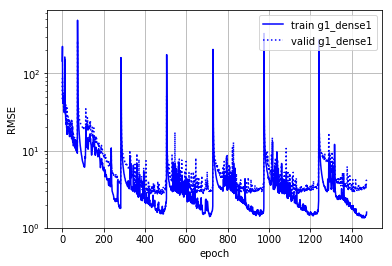

In [37]:
plot_loss([g1_model1_hist],['g1_dense1'])

In [38]:
g1_model1BN = Sequential()
g1_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1BN.add(Dense(100, activation='relu'))
g1_model1BN.add(BatchNormalization())
g1_model1BN.add(Dense(30))
print(g1_model1BN.summary())
g1_model1BN_hist, g1_model1BN = fit_model(g1_model1BN, data1,
                                    'g1_1dense100neuronlayer_wbatchnormalization')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_16 (Dense)             (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None
10000
Train on 1709 samples, validate on 428 samples
Epoch 1/10000
1709/1709 [==============================] - 1s 627us/step - loss: 0.2881 - val_loss: 0.0576
Epoch 2/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0197 - val_loss: 0

1709/1709 [==============================] - 1s 321us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 69/10000
1709/1709 [==============================] - 1s 339us/step - loss: 0.0020 - val_loss: 0.0049
Epoch 70/10000
1709/1709 [==============================] - 1s 320us/step - loss: 0.0019 - val_loss: 0.0059
Epoch 71/10000
1709/1709 [==============================] - 1s 329us/step - loss: 0.0018 - val_loss: 0.0093
Epoch 72/10000
1709/1709 [==============================] - 1s 333us/step - loss: 0.0020 - val_loss: 0.0037
Epoch 73/10000
1709/1709 [==============================] - 1s 337us/step - loss: 0.0016 - val_loss: 0.0047
Epoch 74/10000
1709/1709 [==============================] - 1s 330us/step - loss: 0.0018 - val_loss: 0.0043
Epoch 75/10000
1709/1709 [==============================] - 1s 331us/step - loss: 0.0016 - val_loss: 0.0051
Epoch 76/10000
1709/1709 [==============================] - 1s 320us/step - loss: 0.0021 - val_loss: 0.0038
Epoch 77/10000
1709/1709 [=================

1709/1709 [==============================] - 1s 320us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 144/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 145/10000
1709/1709 [==============================] - 1s 315us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 146/10000
1709/1709 [==============================] - 1s 325us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 147/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0010 - val_loss: 0.0045
Epoch 148/10000
1709/1709 [==============================] - 1s 321us/step - loss: 0.0012 - val_loss: 0.0028
Epoch 149/10000
1709/1709 [==============================] - 1s 319us/step - loss: 0.0010 - val_loss: 0.0032
Epoch 150/10000
1709/1709 [==============================] - 1s 328us/step - loss: 0.0012 - val_loss: 0.0037
Epoch 151/10000
1709/1709 [==============================] - 1s 331us/step - loss: 0.0013 - val_loss: 0.0040
Epoch 152/10000
1709/1709 [========

1709/1709 [==============================] - 1s 323us/step - loss: 8.9580e-04 - val_loss: 0.0025
Epoch 218/10000
1709/1709 [==============================] - 1s 323us/step - loss: 9.4131e-04 - val_loss: 0.0034
Epoch 219/10000
1709/1709 [==============================] - 1s 313us/step - loss: 9.8445e-04 - val_loss: 0.0032
Epoch 220/10000
1709/1709 [==============================] - 1s 318us/step - loss: 9.8741e-04 - val_loss: 0.0032
Epoch 221/10000
1709/1709 [==============================] - 1s 314us/step - loss: 8.7984e-04 - val_loss: 0.0026
Epoch 222/10000
1709/1709 [==============================] - 1s 320us/step - loss: 8.7905e-04 - val_loss: 0.0032
Epoch 223/10000
1709/1709 [==============================] - 1s 319us/step - loss: 9.4438e-04 - val_loss: 0.0028
Epoch 224/10000
1709/1709 [==============================] - 1s 317us/step - loss: 8.7378e-04 - val_loss: 0.0031
Epoch 225/10000
1709/1709 [==============================] - 1s 320us/step - loss: 8.3458e-04 - val_loss: 0.0028

1709/1709 [==============================] - 1s 319us/step - loss: 7.5033e-04 - val_loss: 0.0027
Epoch 290/10000
1709/1709 [==============================] - 1s 319us/step - loss: 7.3597e-04 - val_loss: 0.0026
Epoch 291/10000
1709/1709 [==============================] - 1s 329us/step - loss: 7.0543e-04 - val_loss: 0.0025
Epoch 292/10000
1709/1709 [==============================] - 1s 324us/step - loss: 6.7796e-04 - val_loss: 0.0024
Epoch 293/10000
1709/1709 [==============================] - 1s 328us/step - loss: 6.8308e-04 - val_loss: 0.0026
Epoch 294/10000
1709/1709 [==============================] - 1s 322us/step - loss: 7.0669e-04 - val_loss: 0.0026
Epoch 295/10000
1709/1709 [==============================] - 1s 320us/step - loss: 7.0688e-04 - val_loss: 0.0027
Epoch 296/10000
1709/1709 [==============================] - 1s 334us/step - loss: 7.2111e-04 - val_loss: 0.0026
Epoch 297/10000
1709/1709 [==============================] - 1s 330us/step - loss: 6.6778e-04 - val_loss: 0.0025

1709/1709 [==============================] - 1s 314us/step - loss: 6.8784e-04 - val_loss: 0.0032
Epoch 362/10000
1709/1709 [==============================] - 1s 319us/step - loss: 7.9114e-04 - val_loss: 0.0026
Epoch 363/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.4953e-04 - val_loss: 0.0025
Epoch 364/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.4149e-04 - val_loss: 0.0026
Epoch 365/10000
1709/1709 [==============================] - 1s 314us/step - loss: 7.1246e-04 - val_loss: 0.0027
Epoch 366/10000
1709/1709 [==============================] - 1s 319us/step - loss: 5.9852e-04 - val_loss: 0.0027
Epoch 367/10000
1709/1709 [==============================] - 1s 329us/step - loss: 6.3301e-04 - val_loss: 0.0024
Epoch 368/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.0794e-04 - val_loss: 0.0026
Epoch 369/10000
1709/1709 [==============================] - 1s 314us/step - loss: 6.7401e-04 - val_loss: 0.0025

1709/1709 [==============================] - 1s 315us/step - loss: 5.1762e-04 - val_loss: 0.0024
Epoch 434/10000
1709/1709 [==============================] - 1s 316us/step - loss: 5.0447e-04 - val_loss: 0.0025
Epoch 435/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.3531e-04 - val_loss: 0.0024
Epoch 436/10000
1709/1709 [==============================] - 1s 314us/step - loss: 4.9232e-04 - val_loss: 0.0027
Epoch 437/10000
1709/1709 [==============================] - 1s 326us/step - loss: 5.2673e-04 - val_loss: 0.0024
Epoch 438/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.1138e-04 - val_loss: 0.0025
Epoch 439/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.3110e-04 - val_loss: 0.0024
Epoch 440/10000
1709/1709 [==============================] - 1s 313us/step - loss: 5.1423e-04 - val_loss: 0.0025
Epoch 441/10000
1709/1709 [==============================] - 1s 310us/step - loss: 4.9275e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 321us/step - loss: 4.5735e-04 - val_loss: 0.0024
Epoch 506/10000
1709/1709 [==============================] - 1s 318us/step - loss: 4.4621e-04 - val_loss: 0.0025
Epoch 507/10000
1709/1709 [==============================] - 1s 315us/step - loss: 4.2454e-04 - val_loss: 0.0023
Epoch 508/10000
1709/1709 [==============================] - 1s 317us/step - loss: 4.5124e-04 - val_loss: 0.0024
Epoch 509/10000
1709/1709 [==============================] - 1s 311us/step - loss: 4.0700e-04 - val_loss: 0.0024
Epoch 510/10000
1709/1709 [==============================] - 1s 319us/step - loss: 4.5299e-04 - val_loss: 0.0025
Epoch 511/10000
1709/1709 [==============================] - 1s 316us/step - loss: 4.6732e-04 - val_loss: 0.0024
Epoch 512/10000
1709/1709 [==============================] - 1s 317us/step - loss: 4.5860e-04 - val_loss: 0.0024
Epoch 513/10000
1709/1709 [==============================] - 1s 314us/step - loss: 4.4662e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 326us/step - loss: 3.9983e-04 - val_loss: 0.0023
Epoch 578/10000
1709/1709 [==============================] - 1s 318us/step - loss: 3.8767e-04 - val_loss: 0.0026
Epoch 579/10000
1709/1709 [==============================] - 1s 330us/step - loss: 3.9444e-04 - val_loss: 0.0023
Epoch 580/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.6634e-04 - val_loss: 0.0023
Epoch 581/10000
1709/1709 [==============================] - 1s 321us/step - loss: 4.0308e-04 - val_loss: 0.0024
Epoch 582/10000
1709/1709 [==============================] - 1s 316us/step - loss: 3.6901e-04 - val_loss: 0.0023
Epoch 583/10000
1709/1709 [==============================] - 1s 314us/step - loss: 3.5353e-04 - val_loss: 0.0023
Epoch 584/10000
1709/1709 [==============================] - 1s 311us/step - loss: 3.9030e-04 - val_loss: 0.0024
Epoch 585/10000
1709/1709 [==============================] - 1s 322us/step - loss: 3.9691e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 325us/step - loss: 3.3187e-04 - val_loss: 0.0023
Epoch 650/10000
1709/1709 [==============================] - 1s 320us/step - loss: 3.5102e-04 - val_loss: 0.0023
Epoch 651/10000
1709/1709 [==============================] - 1s 329us/step - loss: 3.6303e-04 - val_loss: 0.0023
Epoch 652/10000
1709/1709 [==============================] - 1s 317us/step - loss: 3.5258e-04 - val_loss: 0.0023
Epoch 653/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.3363e-04 - val_loss: 0.0023
Epoch 654/10000
1709/1709 [==============================] - 1s 324us/step - loss: 3.6359e-04 - val_loss: 0.0023
Epoch 655/10000
1709/1709 [==============================] - 1s 313us/step - loss: 3.4958e-04 - val_loss: 0.0023
Epoch 656/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.2767e-04 - val_loss: 0.0023
Epoch 657/10000
1709/1709 [==============================] - 1s 329us/step - loss: 3.4358e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 316us/step - loss: 3.0554e-04 - val_loss: 0.0023
Epoch 722/10000
1709/1709 [==============================] - 1s 313us/step - loss: 3.4155e-04 - val_loss: 0.0022
Epoch 723/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.9020e-04 - val_loss: 0.0023
Epoch 724/10000
1709/1709 [==============================] - 1s 321us/step - loss: 3.1710e-04 - val_loss: 0.0023
Epoch 725/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.3603e-04 - val_loss: 0.0022
Epoch 726/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.0572e-04 - val_loss: 0.0023
Epoch 727/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.1411e-04 - val_loss: 0.0022
Epoch 728/10000
1709/1709 [==============================] - 1s 321us/step - loss: 3.2655e-04 - val_loss: 0.0023
Epoch 729/10000
1709/1709 [==============================] - 1s 304us/step - loss: 3.2780e-04 - val_loss: 0.0022

1709/1709 [==============================] - 1s 332us/step - loss: 2.9904e-04 - val_loss: 0.0023
Epoch 794/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.8319e-04 - val_loss: 0.0023
Epoch 795/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.9756e-04 - val_loss: 0.0022
Epoch 796/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8286e-04 - val_loss: 0.0022
Epoch 797/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.8824e-04 - val_loss: 0.0022
Epoch 798/10000
1709/1709 [==============================] - 1s 318us/step - loss: 3.0475e-04 - val_loss: 0.0023
Epoch 799/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.8641e-04 - val_loss: 0.0022
Epoch 800/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.9742e-04 - val_loss: 0.0023
Epoch 801/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.9366e-04 - val_loss: 0.0023

1709/1709 [==============================] - 1s 309us/step - loss: 2.7255e-04 - val_loss: 0.0022
Epoch 866/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.5502e-04 - val_loss: 0.0022
Epoch 867/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.8412e-04 - val_loss: 0.0022
Epoch 868/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.7320e-04 - val_loss: 0.0022
Epoch 869/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.7178e-04 - val_loss: 0.0022
Epoch 870/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8112e-04 - val_loss: 0.0023
Epoch 871/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8028e-04 - val_loss: 0.0022
Epoch 872/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.6965e-04 - val_loss: 0.0023
Epoch 873/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.7608e-04 - val_loss: 0.0023

1709/1709 [==============================] - 1s 320us/step - loss: 2.6355e-04 - val_loss: 0.0023
Epoch 938/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.8010e-04 - val_loss: 0.0022
Epoch 939/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.5705e-04 - val_loss: 0.0023
Epoch 940/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.8362e-04 - val_loss: 0.0022
Epoch 941/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.4740e-04 - val_loss: 0.0022
Epoch 942/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.6262e-04 - val_loss: 0.0022
Epoch 943/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.5715e-04 - val_loss: 0.0022
Epoch 944/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.6745e-04 - val_loss: 0.0023
Epoch 945/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.5083e-04 - val_loss: 0.0022

1709/1709 [==============================] - 1s 327us/step - loss: 2.4795e-04 - val_loss: 0.0022
Epoch 1010/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.5700e-04 - val_loss: 0.0023
Epoch 1011/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.4434e-04 - val_loss: 0.0022
Epoch 1012/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.5582e-04 - val_loss: 0.0022
Epoch 1013/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.3344e-04 - val_loss: 0.0022
Epoch 1014/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.6361e-04 - val_loss: 0.0022
Epoch 1015/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.3555e-04 - val_loss: 0.0022
Epoch 1016/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2984e-04 - val_loss: 0.0022
Epoch 1017/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3111e-04 - val_loss

1709/1709 [==============================] - 1s 321us/step - loss: 2.2414e-04 - val_loss: 0.0022
Epoch 1082/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.3607e-04 - val_loss: 0.0022
Epoch 1083/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.5785e-04 - val_loss: 0.0022
Epoch 1084/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.4123e-04 - val_loss: 0.0022
Epoch 1085/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.4122e-04 - val_loss: 0.0022
Epoch 1086/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3875e-04 - val_loss: 0.0022
Epoch 1087/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.3471e-04 - val_loss: 0.0022
Epoch 1088/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.4826e-04 - val_loss: 0.0022
Epoch 1089/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.3099e-04 - val_loss

1709/1709 [==============================] - 1s 315us/step - loss: 2.3081e-04 - val_loss: 0.0022
Epoch 1154/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2517e-04 - val_loss: 0.0022
Epoch 1155/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.4045e-04 - val_loss: 0.0022
Epoch 1156/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3486e-04 - val_loss: 0.0022
Epoch 1157/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3569e-04 - val_loss: 0.0022
Epoch 1158/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.2582e-04 - val_loss: 0.0022
Epoch 1159/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.4395e-04 - val_loss: 0.0023
Epoch 1160/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.3752e-04 - val_loss: 0.0022
Epoch 1161/10000
1709/1709 [==============================] - 1s 306us/step - loss: 2.3054e-04 - val_loss

1709/1709 [==============================] - 1s 326us/step - loss: 2.4761e-04 - val_loss: 0.0023
Epoch 1226/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.3397e-04 - val_loss: 0.0022
Epoch 1227/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.3219e-04 - val_loss: 0.0022
Epoch 1228/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3877e-04 - val_loss: 0.0022
Epoch 1229/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2687e-04 - val_loss: 0.0022
Epoch 1230/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.5588e-04 - val_loss: 0.0022
Epoch 1231/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4539e-04 - val_loss: 0.0022
Epoch 1232/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.2669e-04 - val_loss: 0.0022
Epoch 1233/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.3727e-04 - val_loss

1709/1709 [==============================] - 1s 317us/step - loss: 2.3838e-04 - val_loss: 0.0022
Epoch 1298/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.3753e-04 - val_loss: 0.0023
Epoch 1299/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.2671e-04 - val_loss: 0.0023
Epoch 1300/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.2277e-04 - val_loss: 0.0022
Epoch 1301/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.3764e-04 - val_loss: 0.0022
Epoch 1302/10000
1709/1709 [==============================] - 1s 329us/step - loss: 2.0734e-04 - val_loss: 0.0022
Epoch 1303/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.4153e-04 - val_loss: 0.0022
Epoch 1304/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.2364e-04 - val_loss: 0.0022
Epoch 1305/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.3585e-04 - val_loss

1709/1709 [==============================] - 1s 317us/step - loss: 2.2343e-04 - val_loss: 0.0022
Epoch 1370/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.3727e-04 - val_loss: 0.0022
Epoch 1371/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.3205e-04 - val_loss: 0.0022
Epoch 1372/10000
1709/1709 [==============================] - 1s 322us/step - loss: 2.2936e-04 - val_loss: 0.0022
Epoch 1373/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.2906e-04 - val_loss: 0.0023
Epoch 1374/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.2338e-04 - val_loss: 0.0022
Epoch 1375/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3033e-04 - val_loss: 0.0022
Epoch 1376/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.2341e-04 - val_loss: 0.0023
Epoch 1377/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.3997e-04 - val_loss

1709/1709 [==============================] - 1s 364us/step - loss: 2.1337e-04 - val_loss: 0.0023
Epoch 1442/10000
1709/1709 [==============================] - 2s 1ms/step - loss: 2.3212e-04 - val_loss: 0.0022
Epoch 1443/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.5342e-04 - val_loss: 0.0022
Epoch 1444/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.0377e-04 - val_loss: 0.0022
Epoch 1445/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.4127e-04 - val_loss: 0.0022
Epoch 1446/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.1931e-04 - val_loss: 0.0022
Epoch 1447/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.2832e-04 - val_loss: 0.0022
Epoch 1448/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1495e-04 - val_loss: 0.0022
Epoch 1449/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.3157e-04 - val_loss: 

1709/1709 [==============================] - 1s 316us/step - loss: 2.4105e-04 - val_loss: 0.0022
Epoch 1514/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.0370e-04 - val_loss: 0.0022
Epoch 1515/10000
1709/1709 [==============================] - 1s 306us/step - loss: 2.2729e-04 - val_loss: 0.0022
Epoch 1516/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4245e-04 - val_loss: 0.0022
Epoch 1517/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1377e-04 - val_loss: 0.0022
Epoch 1518/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2784e-04 - val_loss: 0.0022
Epoch 1519/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3148e-04 - val_loss: 0.0023
Epoch 1520/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2079e-04 - val_loss: 0.0022
Epoch 1521/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.5347e-04 - val_loss

1709/1709 [==============================] - 1s 312us/step - loss: 2.0891e-04 - val_loss: 0.0022
Epoch 1586/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.2367e-04 - val_loss: 0.0022
Epoch 1587/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2757e-04 - val_loss: 0.0023
Epoch 1588/10000
1709/1709 [==============================] - 1s 313us/step - loss: 1.9691e-04 - val_loss: 0.0022
Epoch 1589/10000
1709/1709 [==============================] - 1s 307us/step - loss: 2.1770e-04 - val_loss: 0.0023
Epoch 1590/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.2188e-04 - val_loss: 0.0022
Epoch 1591/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3251e-04 - val_loss: 0.0022
Epoch 1592/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1633e-04 - val_loss: 0.0022
Epoch 1593/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1092e-04 - val_loss

1709/1709 [==============================] - 1s 309us/step - loss: 2.3965e-04 - val_loss: 0.0022
Epoch 1658/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.3140e-04 - val_loss: 0.0023
Epoch 1659/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1851e-04 - val_loss: 0.0022
Epoch 1660/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2262e-04 - val_loss: 0.0022
Epoch 1661/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.1593e-04 - val_loss: 0.0022
Epoch 1662/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2212e-04 - val_loss: 0.0022
Epoch 1663/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.0458e-04 - val_loss: 0.0022
Epoch 1664/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.0876e-04 - val_loss: 0.0022
Epoch 1665/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1246e-04 - val_loss

1709/1709 [==============================] - 1s 314us/step - loss: 2.1769e-04 - val_loss: 0.0022
Epoch 1730/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4181e-04 - val_loss: 0.0023
Epoch 1731/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.1152e-04 - val_loss: 0.0022
Epoch 1732/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.3085e-04 - val_loss: 0.0023
Epoch 1733/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1199e-04 - val_loss: 0.0022
Epoch 1734/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.2894e-04 - val_loss: 0.0022
Epoch 1735/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.0337e-04 - val_loss: 0.0022
Epoch 1736/10000
1709/1709 [==============================] - 1s 311us/step - loss: 1.9301e-04 - val_loss: 0.0022
Epoch 1737/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.1643e-04 - val_loss

1709/1709 [==============================] - 1s 316us/step - loss: 2.2691e-04 - val_loss: 0.0022
Epoch 1802/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.3663e-04 - val_loss: 0.0022
Epoch 1803/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.2207e-04 - val_loss: 0.0022
Epoch 1804/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.0035e-04 - val_loss: 0.0022
Epoch 1805/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.4044e-04 - val_loss: 0.0022
Epoch 1806/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.0899e-04 - val_loss: 0.0023
Epoch 1807/10000
1709/1709 [==============================] - 1s 315us/step - loss: 1.9215e-04 - val_loss: 0.0022
Epoch 1808/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.2560e-04 - val_loss: 0.0022
Epoch 1809/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.2960e-04 - val_loss

1709/1709 [==============================] - 1s 325us/step - loss: 1.9556e-04 - val_loss: 0.0022
Epoch 1874/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.1196e-04 - val_loss: 0.0023
Epoch 1875/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3848e-04 - val_loss: 0.0022
Epoch 1876/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.2198e-04 - val_loss: 0.0022
Epoch 1877/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.0390e-04 - val_loss: 0.0023
Epoch 1878/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3005e-04 - val_loss: 0.0022
Epoch 1879/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1042e-04 - val_loss: 0.0023
Epoch 1880/10000
1709/1709 [==============================] - 1s 307us/step - loss: 2.3090e-04 - val_loss: 0.0022
Epoch 1881/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.1100e-04 - val_loss

1709/1709 [==============================] - 1s 318us/step - loss: 2.2014e-04 - val_loss: 0.0023
Epoch 1946/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2759e-04 - val_loss: 0.0023
Epoch 1947/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2377e-04 - val_loss: 0.0022
Epoch 1948/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.0598e-04 - val_loss: 0.0022
Epoch 1949/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1398e-04 - val_loss: 0.0022
Epoch 1950/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.1437e-04 - val_loss: 0.0022
Epoch 1951/10000
1709/1709 [==============================] - 1s 313us/step - loss: 1.9479e-04 - val_loss: 0.0022
Epoch 1952/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.0924e-04 - val_loss: 0.0023
Epoch 1953/10000
1709/1709 [==============================] - 1s 317us/step - loss: 1.9929e-04 - val_loss

1709/1709 [==============================] - 1s 320us/step - loss: 2.0607e-04 - val_loss: 0.0022
Epoch 2018/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.0290e-04 - val_loss: 0.0022
Epoch 2019/10000
1709/1709 [==============================] - 1s 395us/step - loss: 1.9063e-04 - val_loss: 0.0022
Epoch 2020/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.2280e-04 - val_loss: 0.0022
Epoch 2021/10000
1709/1709 [==============================] - 1s 304us/step - loss: 2.3426e-04 - val_loss: 0.0023
Epoch 2022/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.0963e-04 - val_loss: 0.0023
Epoch 2023/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.1845e-04 - val_loss: 0.0023
Epoch 2024/10000
1709/1709 [==============================] - 1s 329us/step - loss: 2.1691e-04 - val_loss: 0.0022
Epoch 2025/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.0142e-04 - val_loss

1709/1709 [==============================] - 1s 313us/step - loss: 2.0990e-04 - val_loss: 0.0022
Epoch 2090/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2643e-04 - val_loss: 0.0022
Epoch 2091/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.0097e-04 - val_loss: 0.0023
Epoch 2092/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.0728e-04 - val_loss: 0.0022
Epoch 2093/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.0298e-04 - val_loss: 0.0022
Epoch 2094/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2192e-04 - val_loss: 0.0023
Epoch 2095/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.1126e-04 - val_loss: 0.0022
Epoch 2096/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.3020e-04 - val_loss: 0.0022
Epoch 2097/10000
1709/1709 [==============================] - 1s 322us/step - loss: 2.1858e-04 - val_loss

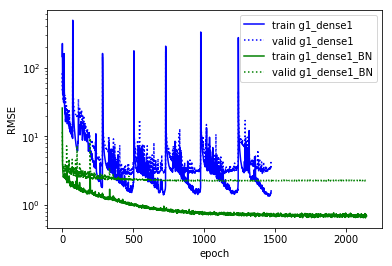

In [39]:
plot_loss([g1_model1_hist, g1_model1BN_hist],['g1_dense1','g1_dense1_BN'])

### Model with convolutions

In [40]:
g1_model2 = Sequential()
g1_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Flatten())
g1_model2.add(Dense(500, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(100, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(30))
print(g1_model2.summary())

g1_model2_hist, g1_model2 = fit_model(g1_model2, data1,
                                    'g1_CNN')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

Epoch 56/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 57/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 58/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 59/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 60/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 61/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 62/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 63/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 64/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 65/10000
1709/1709 [====================

Epoch 132/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.6435e-04 - val_loss: 0.0014
Epoch 133/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.7296e-04 - val_loss: 0.0014
Epoch 134/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.6571e-04 - val_loss: 0.0023
Epoch 135/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 136/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 8.8952e-04 - val_loss: 0.0015
Epoch 137/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.5554e-04 - val_loss: 0.0015
Epoch 138/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.4052e-04 - val_loss: 0.0024
Epoch 139/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.5856e-04 - val_loss: 0.0014
Epoch 140/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.8487e-04 - val_loss: 0.0017
Epoch

Epoch 206/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.1448e-04 - val_loss: 0.0014
Epoch 207/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.2002e-04 - val_loss: 0.0011
Epoch 208/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.8989e-04 - val_loss: 0.0013
Epoch 209/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.6592e-04 - val_loss: 0.0021
Epoch 210/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4990e-04 - val_loss: 0.0013
Epoch 211/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4268e-04 - val_loss: 0.0012
Epoch 212/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.2702e-04 - val_loss: 0.0015
Epoch 213/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4226e-04 - val_loss: 0.0015
Epoch 214/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.9522e-04 - val_loss: 0.0011
E

Epoch 280/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1385e-04 - val_loss: 0.0014
Epoch 281/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 5.0375e-04 - val_loss: 0.0012
Epoch 282/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.4028e-04 - val_loss: 0.0012
Epoch 283/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1389e-04 - val_loss: 0.0012
Epoch 284/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.5242e-04 - val_loss: 0.0013
Epoch 285/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1490e-04 - val_loss: 0.0011
Epoch 286/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.5706e-04 - val_loss: 0.0012
Epoch 287/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1047e-04 - val_loss: 0.0012
Epoch 288/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.4278e-04 - val_loss: 0.0012
E

1709/1709 [==============================] - 4s 3ms/step - loss: 4.2116e-04 - val_loss: 0.0011
Epoch 354/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8980e-04 - val_loss: 0.0011
Epoch 355/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1432e-04 - val_loss: 0.0012
Epoch 356/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.0939e-04 - val_loss: 0.0012
Epoch 357/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8609e-04 - val_loss: 0.0012
Epoch 358/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.0359e-04 - val_loss: 0.0011
Epoch 359/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.7942e-04 - val_loss: 0.0015
Epoch 360/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8706e-04 - val_loss: 0.0014
Epoch 361/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.9748e-04 - val_loss: 0.0011
Epoch 362/10000
1

Epoch 427/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3763e-04 - val_loss: 9.9342e-04
Epoch 428/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.2725e-04 - val_loss: 0.0012
Epoch 429/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.4530e-04 - val_loss: 0.0010
Epoch 430/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.6033e-04 - val_loss: 0.0010
Epoch 431/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1418e-04 - val_loss: 0.0012
Epoch 432/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.4123e-04 - val_loss: 0.0012
Epoch 433/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.2568e-04 - val_loss: 0.0011
Epoch 434/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3732e-04 - val_loss: 0.0011
Epoch 435/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1413e-04 - val_loss: 0.00

1709/1709 [==============================] - 5s 3ms/step - loss: 2.9685e-04 - val_loss: 0.0012
Epoch 501/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1691e-04 - val_loss: 0.0011
Epoch 502/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1124e-04 - val_loss: 0.0011
Epoch 503/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9833e-04 - val_loss: 9.8713e-04
Epoch 504/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9694e-04 - val_loss: 9.9150e-04
Epoch 505/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0270e-04 - val_loss: 0.0012
Epoch 506/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3010e-04 - val_loss: 0.0013
Epoch 507/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0477e-04 - val_loss: 0.0010
Epoch 508/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0336e-04 - val_loss: 0.0010
Epoch 509

1709/1709 [==============================] - 5s 3ms/step - loss: 3.1355e-04 - val_loss: 9.7630e-04
Epoch 574/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8846e-04 - val_loss: 9.8662e-04
Epoch 575/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9462e-04 - val_loss: 0.0012
Epoch 576/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0133e-04 - val_loss: 9.7813e-04
Epoch 577/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.5749e-04 - val_loss: 0.0011
Epoch 578/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9093e-04 - val_loss: 9.3954e-04
Epoch 579/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8039e-04 - val_loss: 0.0010
Epoch 580/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.7112e-04 - val_loss: 9.8298e-04
Epoch 581/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.7570e-04 - val_loss: 0.00

1709/1709 [==============================] - 5s 3ms/step - loss: 2.6719e-04 - val_loss: 0.0010
Epoch 646/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4846e-04 - val_loss: 0.0010
Epoch 647/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6115e-04 - val_loss: 9.1737e-04
Epoch 648/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6134e-04 - val_loss: 0.0010
Epoch 649/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9082e-04 - val_loss: 0.0011
Epoch 650/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9953e-04 - val_loss: 0.0011
Epoch 651/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8205e-04 - val_loss: 0.0012
Epoch 652/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9066e-04 - val_loss: 9.8542e-04
Epoch 653/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6812e-04 - val_loss: 0.0011
Epoch 654

Epoch 717/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3031e-04 - val_loss: 9.3094e-04
Epoch 718/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4023e-04 - val_loss: 9.5341e-04
Epoch 719/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3807e-04 - val_loss: 9.1877e-04
Epoch 720/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1476e-04 - val_loss: 9.4287e-04
Epoch 721/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3959e-04 - val_loss: 9.4234e-04
Epoch 722/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4936e-04 - val_loss: 9.4040e-04
Epoch 723/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4527e-04 - val_loss: 9.0996e-04
Epoch 724/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0395e-04 - val_loss: 9.3331e-04
Epoch 725/10000
1709/1709 [==============================] - 5s 3ms/step - loss:

1709/1709 [==============================] - 5s 3ms/step - loss: 1.9892e-04 - val_loss: 9.4995e-04
Epoch 789/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3067e-04 - val_loss: 9.5218e-04
Epoch 790/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2318e-04 - val_loss: 9.6288e-04
Epoch 791/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4866e-04 - val_loss: 9.4041e-04
Epoch 792/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3093e-04 - val_loss: 9.5299e-04
Epoch 793/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3624e-04 - val_loss: 9.1794e-04
Epoch 794/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1961e-04 - val_loss: 9.6572e-04
Epoch 795/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4682e-04 - val_loss: 9.3521e-04
Epoch 796/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3192e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.2191e-04 - val_loss: 9.1304e-04
Epoch 860/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0828e-04 - val_loss: 8.8587e-04
Epoch 861/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2051e-04 - val_loss: 9.0768e-04
Epoch 862/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3439e-04 - val_loss: 9.2687e-04
Epoch 863/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2257e-04 - val_loss: 9.1704e-04
Epoch 864/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0297e-04 - val_loss: 9.3529e-04
Epoch 865/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3126e-04 - val_loss: 9.0876e-04
Epoch 866/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1257e-04 - val_loss: 9.1188e-04
Epoch 867/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1932e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.0950e-04 - val_loss: 9.1261e-04
Epoch 931/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1074e-04 - val_loss: 9.2289e-04
Epoch 932/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1073e-04 - val_loss: 9.0097e-04
Epoch 933/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3211e-04 - val_loss: 8.8016e-04
Epoch 934/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0950e-04 - val_loss: 8.8744e-04
Epoch 935/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9867e-04 - val_loss: 9.3040e-04
Epoch 936/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2332e-04 - val_loss: 9.0559e-04
Epoch 937/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1922e-04 - val_loss: 9.1755e-04
Epoch 938/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9678e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.1946e-04 - val_loss: 9.0361e-04
Epoch 1002/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9881e-04 - val_loss: 9.1494e-04
Epoch 1003/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9956e-04 - val_loss: 8.9595e-04
Epoch 1004/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9948e-04 - val_loss: 8.8609e-04
Epoch 1005/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.3196e-04 - val_loss: 8.9742e-04
Epoch 1006/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1531e-04 - val_loss: 8.9112e-04
Epoch 1007/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0952e-04 - val_loss: 8.7249e-04
Epoch 1008/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.1100e-04 - val_loss: 9.1198e-04
Epoch 1009/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.4284e

Epoch 1072/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0632e-04 - val_loss: 8.7360e-04
Epoch 1073/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0230e-04 - val_loss: 8.8485e-04
Epoch 1074/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8160e-04 - val_loss: 8.7037e-04
Epoch 1075/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8030e-04 - val_loss: 8.7026e-04
Epoch 1076/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7672e-04 - val_loss: 8.8337e-04
Epoch 1077/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9272e-04 - val_loss: 8.9161e-04
Epoch 1078/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9073e-04 - val_loss: 8.7081e-04
Epoch 1079/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9787e-04 - val_loss: 8.6802e-04
Epoch 1080/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.9704e-04 - val_loss: 8.7496e-04
Epoch 1143/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0422e-04 - val_loss: 8.7983e-04
Epoch 1144/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9660e-04 - val_loss: 8.8656e-04
Epoch 1145/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9317e-04 - val_loss: 8.9887e-04
Epoch 1146/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8872e-04 - val_loss: 8.6066e-04
Epoch 1147/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0439e-04 - val_loss: 8.9121e-04
Epoch 1148/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8988e-04 - val_loss: 9.0859e-04
Epoch 1149/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9449e-04 - val_loss: 8.6641e-04
Epoch 1150/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7527e

Epoch 1213/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8755e-04 - val_loss: 8.7738e-04
Epoch 1214/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8067e-04 - val_loss: 8.7698e-04
Epoch 1215/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7497e-04 - val_loss: 8.7941e-04
Epoch 1216/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1631e-04 - val_loss: 8.6306e-04
Epoch 1217/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8587e-04 - val_loss: 8.8457e-04
Epoch 1218/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9475e-04 - val_loss: 8.7909e-04
Epoch 1219/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8971e-04 - val_loss: 8.6937e-04
Epoch 1220/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9152e-04 - val_loss: 8.5605e-04
Epoch 1221/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 5s 3ms/step - loss: 1.9651e-04 - val_loss: 8.9514e-04
Epoch 1284/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8874e-04 - val_loss: 8.9146e-04
Epoch 1285/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9034e-04 - val_loss: 8.8871e-04
Epoch 1286/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9136e-04 - val_loss: 8.5764e-04
Epoch 1287/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1910e-04 - val_loss: 8.9010e-04
Epoch 1288/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1687e-04 - val_loss: 8.9583e-04
Epoch 1289/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7687e-04 - val_loss: 8.4979e-04
Epoch 1290/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8812e-04 - val_loss: 8.7366e-04
Epoch 1291/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0111e

Epoch 1354/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9095e-04 - val_loss: 8.6298e-04
Epoch 1355/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9953e-04 - val_loss: 8.8093e-04
Epoch 1356/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7946e-04 - val_loss: 8.6396e-04
Epoch 1357/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8484e-04 - val_loss: 8.6878e-04
Epoch 1358/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0816e-04 - val_loss: 8.9003e-04
Epoch 1359/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0008e-04 - val_loss: 8.6999e-04
Epoch 1360/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7681e-04 - val_loss: 9.0085e-04
Epoch 1361/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8861e-04 - val_loss: 8.8387e-04
Epoch 1362/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 5s 3ms/step - loss: 1.6904e-04 - val_loss: 8.4591e-04
Epoch 1425/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8677e-04 - val_loss: 8.8628e-04
Epoch 1426/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8459e-04 - val_loss: 8.6082e-04
Epoch 1427/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2698e-04 - val_loss: 8.8701e-04
Epoch 1428/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7951e-04 - val_loss: 8.6079e-04
Epoch 1429/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9923e-04 - val_loss: 8.6207e-04
Epoch 1430/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7584e-04 - val_loss: 8.7315e-04
Epoch 1431/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8873e-04 - val_loss: 8.7414e-04
Epoch 1432/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0132e

Epoch 1495/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7772e-04 - val_loss: 8.8473e-04
Epoch 1496/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7399e-04 - val_loss: 8.6106e-04
Epoch 1497/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7529e-04 - val_loss: 8.6588e-04
Epoch 1498/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0199e-04 - val_loss: 8.6189e-04
Epoch 1499/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8341e-04 - val_loss: 8.7359e-04
Epoch 1500/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6618e-04 - val_loss: 8.6930e-04
Epoch 1501/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9300e-04 - val_loss: 9.0701e-04
Epoch 1502/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0982e-04 - val_loss: 8.5769e-04
Epoch 1503/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6103e-04 - val_loss: 8.7262e-04
Epoch 1566/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7775e-04 - val_loss: 8.4734e-04
Epoch 1567/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0234e-04 - val_loss: 8.7969e-04
Epoch 1568/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8923e-04 - val_loss: 8.6017e-04
Epoch 1569/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6353e-04 - val_loss: 8.7205e-04
Epoch 1570/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8255e-04 - val_loss: 8.5889e-04
Epoch 1571/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9340e-04 - val_loss: 8.7742e-04
Epoch 1572/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9620e-04 - val_loss: 8.9609e-04
Epoch 1573/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8759e

Epoch 1636/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8691e-04 - val_loss: 8.7013e-04
Epoch 1637/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8912e-04 - val_loss: 8.7542e-04
Epoch 1638/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8082e-04 - val_loss: 8.6961e-04
Epoch 1639/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9413e-04 - val_loss: 8.6455e-04
Epoch 1640/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7473e-04 - val_loss: 8.6781e-04
Epoch 1641/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9036e-04 - val_loss: 8.7457e-04
Epoch 1642/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7646e-04 - val_loss: 8.6739e-04
Epoch 1643/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6670e-04 - val_loss: 8.7109e-04
Epoch 1644/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6405e-04 - val_loss: 8.4491e-04
Epoch 1707/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8566e-04 - val_loss: 8.8005e-04
Epoch 1708/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8072e-04 - val_loss: 8.5803e-04
Epoch 1709/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5024e-04 - val_loss: 8.5342e-04
Epoch 1710/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8793e-04 - val_loss: 8.9388e-04
Epoch 1711/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8218e-04 - val_loss: 8.5675e-04
Epoch 1712/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8237e-04 - val_loss: 8.6702e-04
Epoch 1713/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7015e-04 - val_loss: 8.6196e-04
Epoch 1714/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7937e

Epoch 1777/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7330e-04 - val_loss: 8.6574e-04
Epoch 1778/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7879e-04 - val_loss: 8.7249e-04
Epoch 1779/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7721e-04 - val_loss: 8.5192e-04
Epoch 1780/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7831e-04 - val_loss: 8.6216e-04
Epoch 1781/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7511e-04 - val_loss: 8.6142e-04
Epoch 1782/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6838e-04 - val_loss: 8.6815e-04
Epoch 1783/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8443e-04 - val_loss: 8.6981e-04
Epoch 1784/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9325e-04 - val_loss: 8.5453e-04
Epoch 1785/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7037e-04 - val_loss: 8.7916e-04
Epoch 1848/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8187e-04 - val_loss: 8.7074e-04
Epoch 1849/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8231e-04 - val_loss: 8.5770e-04
Epoch 1850/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8508e-04 - val_loss: 8.5712e-04
Epoch 1851/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8699e-04 - val_loss: 8.6992e-04
Epoch 1852/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8547e-04 - val_loss: 8.5652e-04
Epoch 1853/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6510e-04 - val_loss: 8.6428e-04
Epoch 1854/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8219e-04 - val_loss: 8.5936e-04
Epoch 1855/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8358e

Epoch 1918/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7132e-04 - val_loss: 8.5334e-04
Epoch 1919/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7869e-04 - val_loss: 8.6892e-04
Epoch 1920/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8726e-04 - val_loss: 8.7159e-04
Epoch 1921/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7340e-04 - val_loss: 8.4890e-04
Epoch 1922/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8731e-04 - val_loss: 8.5416e-04
Epoch 1923/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9406e-04 - val_loss: 8.5839e-04
Epoch 1924/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6718e-04 - val_loss: 8.4812e-04
Epoch 1925/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9121e-04 - val_loss: 8.8920e-04
Epoch 1926/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7992e-04 - val_loss: 8.6148e-04
Epoch 1989/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7857e-04 - val_loss: 8.7739e-04
Epoch 1990/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6743e-04 - val_loss: 8.6237e-04
Epoch 1991/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8121e-04 - val_loss: 8.6063e-04
Epoch 1992/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7467e-04 - val_loss: 8.7415e-04
Epoch 1993/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7117e-04 - val_loss: 8.7681e-04
Epoch 1994/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7120e-04 - val_loss: 8.6622e-04
Epoch 1995/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9226e-04 - val_loss: 8.6802e-04
Epoch 1996/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6604e

Epoch 2059/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7407e-04 - val_loss: 8.5561e-04
Epoch 2060/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6861e-04 - val_loss: 8.6978e-04
Epoch 2061/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5161e-04 - val_loss: 8.7232e-04
Epoch 2062/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6949e-04 - val_loss: 8.6640e-04
Epoch 2063/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7450e-04 - val_loss: 8.5337e-04
Epoch 2064/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5644e-04 - val_loss: 8.7220e-04
Epoch 2065/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0717e-04 - val_loss: 8.6830e-04
Epoch 2066/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6791e-04 - val_loss: 8.5162e-04
Epoch 2067/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.9715e-04 - val_loss: 8.6546e-04
Epoch 2130/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7322e-04 - val_loss: 8.6642e-04
Epoch 2131/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7685e-04 - val_loss: 8.6886e-04
Epoch 2132/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6756e-04 - val_loss: 8.6747e-04
Epoch 2133/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6906e-04 - val_loss: 8.7735e-04
Epoch 2134/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5782e-04 - val_loss: 8.6031e-04
Epoch 2135/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9199e-04 - val_loss: 8.7203e-04
Epoch 2136/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6167e-04 - val_loss: 8.5373e-04
Epoch 2137/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6873e

Epoch 2200/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8498e-04 - val_loss: 8.7280e-04
Epoch 2201/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6190e-04 - val_loss: 8.5576e-04
Epoch 2202/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7947e-04 - val_loss: 8.5384e-04
Epoch 2203/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7130e-04 - val_loss: 8.6881e-04
Epoch 2204/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9636e-04 - val_loss: 8.5961e-04
Epoch 2205/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6285e-04 - val_loss: 8.6168e-04
Epoch 2206/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9685e-04 - val_loss: 8.6250e-04
Epoch 2207/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8096e-04 - val_loss: 8.7240e-04
Epoch 2208/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.8392e-04 - val_loss: 8.7001e-04
Epoch 2271/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6827e-04 - val_loss: 8.6599e-04
Epoch 2272/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5507e-04 - val_loss: 8.7429e-04
Epoch 2273/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6215e-04 - val_loss: 8.5157e-04
Epoch 2274/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0121e-04 - val_loss: 8.6944e-04
Epoch 2275/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6622e-04 - val_loss: 8.6512e-04
Epoch 2276/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8489e-04 - val_loss: 8.6672e-04
Epoch 2277/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6251e-04 - val_loss: 8.7240e-04
Epoch 2278/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7326e

Epoch 2341/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8487e-04 - val_loss: 8.7236e-04
Epoch 2342/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6829e-04 - val_loss: 8.6791e-04
Epoch 2343/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6968e-04 - val_loss: 8.8167e-04
Epoch 2344/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.1653e-04 - val_loss: 8.5219e-04
Epoch 2345/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4896e-04 - val_loss: 8.6636e-04
Epoch 2346/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7906e-04 - val_loss: 8.7621e-04
Epoch 2347/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5967e-04 - val_loss: 8.7044e-04
Epoch 2348/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5657e-04 - val_loss: 8.5872e-04
Epoch 2349/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7205e-04 - val_loss: 8.6718e-04
Epoch 2412/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7163e-04 - val_loss: 8.7134e-04
Epoch 2413/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8209e-04 - val_loss: 8.6999e-04
Epoch 2414/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8889e-04 - val_loss: 8.8208e-04
Epoch 2415/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7911e-04 - val_loss: 8.4918e-04
Epoch 2416/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7007e-04 - val_loss: 8.7335e-04
Epoch 2417/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8412e-04 - val_loss: 8.6840e-04
Epoch 2418/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7055e-04 - val_loss: 8.6936e-04
Epoch 2419/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8253e

Epoch 2482/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8978e-04 - val_loss: 8.8709e-04
Epoch 2483/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6428e-04 - val_loss: 8.8022e-04
Epoch 2484/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6620e-04 - val_loss: 8.6301e-04
Epoch 2485/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4808e-04 - val_loss: 8.4914e-04
Epoch 2486/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9814e-04 - val_loss: 8.8674e-04
Epoch 2487/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7149e-04 - val_loss: 8.5761e-04
Epoch 2488/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5369e-04 - val_loss: 8.6290e-04
Epoch 2489/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9125e-04 - val_loss: 8.5855e-04
Epoch 2490/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.8959e-04 - val_loss: 8.5811e-04
Epoch 2553/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7843e-04 - val_loss: 8.8243e-04
Epoch 2554/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5643e-04 - val_loss: 8.6553e-04
Epoch 2555/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9529e-04 - val_loss: 8.6583e-04
Epoch 2556/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7732e-04 - val_loss: 8.6642e-04
Epoch 2557/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6084e-04 - val_loss: 8.6258e-04
Epoch 2558/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7781e-04 - val_loss: 8.6431e-04
Epoch 2559/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6685e-04 - val_loss: 8.6339e-04
Epoch 2560/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6782e

Epoch 2623/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6833e-04 - val_loss: 8.5837e-04
Epoch 2624/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8247e-04 - val_loss: 8.5840e-04
Epoch 2625/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6455e-04 - val_loss: 8.6269e-04
Epoch 2626/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5920e-04 - val_loss: 8.4639e-04
Epoch 2627/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6551e-04 - val_loss: 8.6278e-04
Epoch 2628/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6837e-04 - val_loss: 8.5754e-04
Epoch 2629/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7194e-04 - val_loss: 8.6169e-04
Epoch 2630/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8251e-04 - val_loss: 8.6714e-04
Epoch 2631/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7244e-04 - val_loss: 8.6171e-04
Epoch 2694/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.6884e-04 - val_loss: 8.5820e-04
Epoch 2695/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 1.6699e-04 - val_loss: 8.6685e-04
Epoch 2696/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6954e-04 - val_loss: 8.6741e-04
Epoch 2697/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7034e-04 - val_loss: 8.6680e-04
Epoch 2698/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8821e-04 - val_loss: 8.5790e-04
Epoch 2699/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7667e-04 - val_loss: 8.6148e-04
Epoch 2700/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8881e-04 - val_loss: 8.6750e-04
Epoch 2701/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6248e

Epoch 2764/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8475e-04 - val_loss: 8.5997e-04
Epoch 2765/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7472e-04 - val_loss: 8.6108e-04
Epoch 2766/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6286e-04 - val_loss: 8.6060e-04
Epoch 2767/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6653e-04 - val_loss: 8.8418e-04
Epoch 2768/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6842e-04 - val_loss: 8.4738e-04
Epoch 2769/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7905e-04 - val_loss: 8.6530e-04
Epoch 2770/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5346e-04 - val_loss: 8.4525e-04
Epoch 2771/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6911e-04 - val_loss: 8.6813e-04
Epoch 2772/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.5267e-04 - val_loss: 8.8568e-04
Epoch 2835/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5443e-04 - val_loss: 8.5731e-04
Epoch 2836/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4872e-04 - val_loss: 8.6163e-04
Epoch 2837/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7863e-04 - val_loss: 8.6147e-04
Epoch 2838/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.6065e-04 - val_loss: 8.7207e-04
Epoch 2839/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7914e-04 - val_loss: 8.8472e-04
Epoch 2840/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7134e-04 - val_loss: 8.6362e-04
Epoch 2841/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5353e-04 - val_loss: 8.7526e-04
Epoch 2842/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7832e

Epoch 2905/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6784e-04 - val_loss: 8.6975e-04
Epoch 2906/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 1.8547e-04 - val_loss: 8.5072e-04
Epoch 2907/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8120e-04 - val_loss: 8.7818e-04
Epoch 2908/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8582e-04 - val_loss: 8.5639e-04
Epoch 2909/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5813e-04 - val_loss: 8.5212e-04
Epoch 2910/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7293e-04 - val_loss: 8.6616e-04
Epoch 2911/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6895e-04 - val_loss: 8.6907e-04
Epoch 2912/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6458e-04 - val_loss: 8.5974e-04
Epoch 2913/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6607e-04 - val_loss: 8.5859e-04
Epoch 2976/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5248e-04 - val_loss: 8.6854e-04
Epoch 2977/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5801e-04 - val_loss: 8.5949e-04
Epoch 2978/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5851e-04 - val_loss: 8.6077e-04
Epoch 2979/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8370e-04 - val_loss: 8.7554e-04
Epoch 2980/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7422e-04 - val_loss: 8.5059e-04
Epoch 2981/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6998e-04 - val_loss: 8.5127e-04
Epoch 2982/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9379e-04 - val_loss: 8.4569e-04
Epoch 2983/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5169e

Epoch 3046/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8276e-04 - val_loss: 8.6107e-04
Epoch 3047/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7973e-04 - val_loss: 8.7179e-04
Epoch 3048/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6556e-04 - val_loss: 8.7446e-04
Epoch 3049/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6602e-04 - val_loss: 8.4901e-04
Epoch 3050/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5684e-04 - val_loss: 8.5798e-04
Epoch 3051/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8903e-04 - val_loss: 8.6461e-04
Epoch 3052/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7999e-04 - val_loss: 8.6556e-04
Epoch 3053/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9232e-04 - val_loss: 8.5098e-04
Epoch 3054/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6213e-04 - val_loss: 8.6918e-04
Epoch 3117/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8723e-04 - val_loss: 8.5247e-04
Epoch 3118/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5939e-04 - val_loss: 8.6532e-04
Epoch 3119/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7860e-04 - val_loss: 8.6467e-04
Epoch 3120/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6758e-04 - val_loss: 8.6765e-04
Epoch 3121/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7065e-04 - val_loss: 8.5864e-04
Epoch 3122/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6748e-04 - val_loss: 8.5589e-04
Epoch 3123/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6041e-04 - val_loss: 8.7005e-04
Epoch 3124/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6865e

Epoch 3187/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5471e-04 - val_loss: 8.4318e-04
Epoch 3188/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6480e-04 - val_loss: 8.6163e-04
Epoch 3189/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8472e-04 - val_loss: 8.6969e-04
Epoch 3190/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7101e-04 - val_loss: 8.8235e-04
Epoch 3191/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5725e-04 - val_loss: 8.5850e-04
Epoch 3192/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9252e-04 - val_loss: 8.9114e-04
Epoch 3193/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8044e-04 - val_loss: 8.5988e-04
Epoch 3194/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7218e-04 - val_loss: 8.5484e-04
Epoch 3195/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.5160e-04 - val_loss: 8.7047e-04
Epoch 3258/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6282e-04 - val_loss: 8.7220e-04
Epoch 3259/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6631e-04 - val_loss: 8.6655e-04
Epoch 3260/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6264e-04 - val_loss: 8.6019e-04
Epoch 3261/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8085e-04 - val_loss: 8.5828e-04
Epoch 03261: early stopping


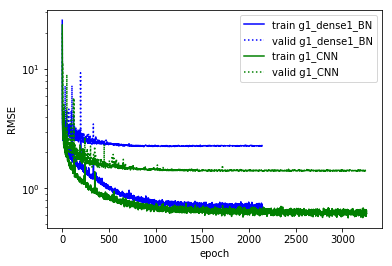

In [41]:
plot_loss([g1_model1BN_hist, g1_model2_hist],['g1_dense1_BN','g1_CNN'])

### Use the custom generator to enhance the training data

In [44]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [ ]:
# basically a copy of model 2, but will train with augmented data
g1_model2_augmented = Sequential()
g1_model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Flatten())
g1_model2_augmented.add(Dense(500, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(100, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(30))
print(g1_model2_augmented.summary())
g1_model2_augmented_hist, g1_model2_augmented = fit_model(g1_model2_augmented, data1,
                                                    'g1_CNN_augmented', datagen)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

53/53 [==============================] - 4s 82ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 59/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 60/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 61/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 62/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 63/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 64/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 65/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 66/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 67/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0024 - va

53/53 [==============================] - 4s 81ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 138/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 139/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 140/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 141/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 142/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 143/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 144/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 145/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 146/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.

Epoch 216/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 217/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 218/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 219/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 220/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 221/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 222/10000
53/53 [==============================] - 4s 79ms/step - loss: 0.0012 - val_loss: 9.9003e-04
Epoch 223/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 224/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 225/10000
53/53 [==============================] - 4s 

53/53 [==============================] - 4s 81ms/step - loss: 8.3379e-04 - val_loss: 9.9385e-04
Epoch 293/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.5592e-04 - val_loss: 8.0277e-04
Epoch 294/10000
53/53 [==============================] - 4s 79ms/step - loss: 8.7852e-04 - val_loss: 9.4379e-04
Epoch 295/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0744e-04 - val_loss: 8.8943e-04
Epoch 296/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.1645e-04 - val_loss: 9.7182e-04
Epoch 297/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.5350e-04 - val_loss: 9.3495e-04
Epoch 298/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.6812e-04 - val_loss: 0.0011
Epoch 299/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.6960e-04 - val_loss: 9.2324e-04
Epoch 300/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.5247e-04 - val_loss: 9.5360e-04
Epoch 301/10

Epoch 366/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.6717e-04 - val_loss: 8.5522e-04
Epoch 367/10000
53/53 [==============================] - 4s 78ms/step - loss: 7.4759e-04 - val_loss: 7.7954e-04
Epoch 368/10000
53/53 [==============================] - 4s 78ms/step - loss: 7.2832e-04 - val_loss: 8.1480e-04
Epoch 369/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.3485e-04 - val_loss: 8.5762e-04
Epoch 370/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.4097e-04 - val_loss: 7.6224e-04
Epoch 371/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.6599e-04 - val_loss: 7.9754e-04
Epoch 372/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.3370e-04 - val_loss: 8.6119e-04
Epoch 373/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.0650e-04 - val_loss: 8.3126e-04
Epoch 374/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.1795e-04 - val_loss: 0.0

53/53 [==============================] - 4s 78ms/step - loss: 6.4352e-04 - val_loss: 7.4131e-04
Epoch 440/10000
53/53 [==============================] - 4s 77ms/step - loss: 7.1101e-04 - val_loss: 7.9187e-04
Epoch 441/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.6603e-04 - val_loss: 7.5040e-04
Epoch 442/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.9950e-04 - val_loss: 6.7614e-04
Epoch 443/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.1859e-04 - val_loss: 7.4059e-04
Epoch 444/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.6561e-04 - val_loss: 7.7457e-04
Epoch 445/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.6150e-04 - val_loss: 6.7419e-04
Epoch 446/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.6142e-04 - val_loss: 7.0822e-04
Epoch 447/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.8497e-04 - val_loss: 7.7355e-04
Epoch 44

53/53 [==============================] - 4s 78ms/step - loss: 5.9389e-04 - val_loss: 7.0053e-04
Epoch 513/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0420e-04 - val_loss: 7.4485e-04
Epoch 514/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.4523e-04 - val_loss: 7.4054e-04
Epoch 515/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.4900e-04 - val_loss: 7.0978e-04
Epoch 516/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.4636e-04 - val_loss: 9.2574e-04
Epoch 517/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.3887e-04 - val_loss: 7.9455e-04
Epoch 518/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.8230e-04 - val_loss: 6.9013e-04
Epoch 519/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0089e-04 - val_loss: 7.8113e-04
Epoch 520/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.2917e-04 - val_loss: 7.6762e-04
Epoch 52

53/53 [==============================] - 4s 79ms/step - loss: 5.7612e-04 - val_loss: 0.0095
Epoch 587/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0249e-04 - val_loss: 0.0013
Epoch 588/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.3164e-04 - val_loss: 0.0018
Epoch 589/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4418e-04 - val_loss: 0.0022
Epoch 590/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.4066e-04 - val_loss: 6.6533e-04
Epoch 591/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.6555e-04 - val_loss: 0.0013
Epoch 592/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.2703e-04 - val_loss: 0.0049
Epoch 593/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4655e-04 - val_loss: 0.0301
Epoch 594/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.9534e-04 - val_loss: 7.0672e-04
Epoch 595/10000
53/53 [=============

53/53 [==============================] - 4s 76ms/step - loss: 4.9175e-04 - val_loss: 6.9206e-04
Epoch 660/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.3156e-04 - val_loss: 6.7128e-04
Epoch 661/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.4679e-04 - val_loss: 7.0018e-04
Epoch 662/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.4079e-04 - val_loss: 7.2116e-04
Epoch 663/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.2376e-04 - val_loss: 6.6708e-04
Epoch 664/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.0884e-04 - val_loss: 7.0151e-04
Epoch 665/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.2751e-04 - val_loss: 6.7759e-04
Epoch 666/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.4653e-04 - val_loss: 6.7074e-04
Epoch 667/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.1662e-04 - val_loss: 6.2828e-04
Epoch 66

53/53 [==============================] - 4s 75ms/step - loss: 4.8813e-04 - val_loss: 6.4531e-04
Epoch 733/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.6884e-04 - val_loss: 6.3725e-04
Epoch 734/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.3541e-04 - val_loss: 6.2283e-04
Epoch 735/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.8998e-04 - val_loss: 6.5056e-04
Epoch 736/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4202e-04 - val_loss: 6.7212e-04
Epoch 737/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.3035e-04 - val_loss: 6.2522e-04
Epoch 738/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.9336e-04 - val_loss: 6.3766e-04
Epoch 739/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.7949e-04 - val_loss: 7.0661e-04
Epoch 740/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.1741e-04 - val_loss: 6.7815e-04
Epoch 74

53/53 [==============================] - 4s 77ms/step - loss: 4.8041e-04 - val_loss: 6.5567e-04
Epoch 806/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.0268e-04 - val_loss: 6.6270e-04
Epoch 807/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.7338e-04 - val_loss: 6.3449e-04
Epoch 808/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.2550e-04 - val_loss: 6.4651e-04
Epoch 809/10000
53/53 [==============================] - 4s 81ms/step - loss: 5.0901e-04 - val_loss: 7.0262e-04
Epoch 810/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.6627e-04 - val_loss: 6.6145e-04
Epoch 811/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.9710e-04 - val_loss: 6.3949e-04
Epoch 812/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.2527e-04 - val_loss: 6.3116e-04
Epoch 813/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.5977e-04 - val_loss: 6.2377e-04
Epoch 81

53/53 [==============================] - 4s 76ms/step - loss: 4.6124e-04 - val_loss: 0.0012
Epoch 879/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.8289e-04 - val_loss: 0.0011
Epoch 880/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.0698e-04 - val_loss: 0.0059
Epoch 881/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0981e-04 - val_loss: 7.5845e-04
Epoch 882/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3220e-04 - val_loss: 0.0015
Epoch 883/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3792e-04 - val_loss: 0.0018
Epoch 884/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.7604e-04 - val_loss: 0.0029
Epoch 885/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.2251e-04 - val_loss: 0.0012
Epoch 886/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.3025e-04 - val_loss: 7.4671e-04
Epoch 887/10000
53/53 [=============

Epoch 953/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2017e-04 - val_loss: 6.2066e-04
Epoch 954/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.4223e-04 - val_loss: 0.0010
Epoch 955/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0377e-04 - val_loss: 6.1133e-04
Epoch 956/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3834e-04 - val_loss: 6.4787e-04
Epoch 957/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.6058e-04 - val_loss: 6.3820e-04
Epoch 958/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1370e-04 - val_loss: 0.0012
Epoch 959/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8928e-04 - val_loss: 6.1599e-04
Epoch 960/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.8621e-04 - val_loss: 6.5144e-04
Epoch 961/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.1194e-04 - val_loss: 6.2729e-04


Epoch 1026/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0964e-04 - val_loss: 5.9683e-04
Epoch 1027/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0726e-04 - val_loss: 6.0872e-04
Epoch 1028/10000
53/53 [==============================] - 4s 81ms/step - loss: 4.0053e-04 - val_loss: 6.0471e-04
Epoch 1029/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.2025e-04 - val_loss: 6.0996e-04
Epoch 1030/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.7113e-04 - val_loss: 6.3355e-04
Epoch 1031/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.7517e-04 - val_loss: 6.1483e-04
Epoch 1032/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2711e-04 - val_loss: 6.2861e-04
Epoch 1033/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.3004e-04 - val_loss: 6.1918e-04
Epoch 1034/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2823e-04 - val_

In [ ]:
plot_loss([model2_hist, model2_augmented_hist],['g1_CNN','g1_CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

### Add Dropout to avoid over-fitting and up the last hidden level

In [ ]:
g1_model3 = Sequential()
g1_model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.1))
g1_model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.2))
g1_model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.3))
g1_model3.add(Flatten())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(Dropout(.5))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(30))
print(g1_model3.summary())
g1_model3_hist, g1_model3 = fit_model(g1_model3, data1,
                                'g1_CNN_aug_dropout',datagen,
                                patience=1000)

In [ ]:
plot_loss([g1_model2_augmented_hist, g1_model3_hist],['g1_CNN_augmented','g1_CNN_aug_dropout'])

## Models for group2 dataset (images with 8 or less keypoints)

### 1 Dense Hidden Layer with 100 units

In [ ]:
g2_model1 = Sequential()
g2_model1.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1.add(Dense(100, activation='relu'))
g2_model1.add(Dense(8))
print(g2_model1.summary())
g2_model1_hist, g2_model1 = fit_model(g2_model1, data2, 'g2_1dense100neuronlayer')

In [ ]:
plot_loss([g2_model1_hist],['g2_dense1'])

### Using batch normalization

In [ ]:
g2_model1BN = Sequential()
g2_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1BN.add(Dense(100, activation='relu'))
g2_model1BN.add(BatchNormalization())
g2_model1BN.add(Dense(8))
print(g2_model1BN.summary())
g2_model1BN_hist, g2_model1BN = fit_model(g2_model1BN, data2,
                                    'g2_1dense100neuronlayer_wbatchnormalization')

In [ ]:
plot_loss([g2_model1_hist, g2_model1BN_hist],['g2_dense1','g2_dense1_BN'])

### Convolutional model 1

In [ ]:
g2_model2 = Sequential()
g2_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Flatten())
g2_model2.add(Dense(500, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(100, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(8))
print(g2_model2.summary())

g2_model2_hist, g2_model2 = fit_model(g2_model2, data2,
                                    'g2_CNNv1')

In [ ]:
plot_loss([g2_model1BN_hist, g2_model2_hist],['g2_dense1_BN', 'g2_CNNv1'])

### Convolutional model 2 with more layers and tweaked kernel sizes

In [ ]:
g2_model3 = Sequential()

g2_model3.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model3.add(BatchNormalization())
#g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.1))

g2_model3.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.3))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.4))

g2_model3.add(Flatten())
g2_model3.add(Dense(500, activation = "elu"))
g2_model3.add(BatchNormalization())
g2_model3.add(Dropout(.4))

#g2_model3.add(Dense(500, activation = "elu"))
#g2_model3.add(BatchNormalization())
#g2_model3.add(Dropout(.4))

g2_model3.add(Dense(100, activation = "elu"))
g2_model3.add(BatchNormalization())

g2_model3.add(Dense(8))

print(g2_model3.summary())

g2_model3_hist, g2_model3 = fit_model(g2_model3, data2,
                                    'g2_CNNv2')

In [ ]:
plot_loss([g2_model1BN_hist, g2_model2_hist, g2_model3_hist],['g2_dense1_BN', 'g2_CNNv1', 'g2_CNNv2'])

### Supplementing the model 3 with augmented data

In [ ]:
g2_datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X2_train,Y2_train,whichlabels=list(labels2), batch_size=32)

In [ ]:
g2_model4 = Sequential()

g2_model4.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model4.add(BatchNormalization())
#g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.1))

g2_model4.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.3))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.4))

g2_model4.add(Flatten())
g2_model4.add(Dense(500, activation = "elu"))
g2_model4.add(BatchNormalization())
g2_model4.add(Dropout(.4))

#g2_model4.add(Dense(500, activation = "elu"))
#g2_model4.add(BatchNormalization())
#g2_model4.add(Dropout(.4))

g2_model4.add(Dense(100, activation = "elu"))
g2_model4.add(BatchNormalization())

g2_model4.add(Dense(8))

print(g2_model4.summary())

g2_model4_hist, g2_model4 = fit_model(g2_model4, data2,
                                'g2_CNNv2_aug', g2_datagen,
                                patience=1000)

In [ ]:
plot_loss([g2_model2_hist, g2_model3_hist, g2_model4_hist],['g2_CNNv1', 'g2_CNNv2', 'g2_CNNv2_aug'])

## Create Predictions
### Load the Testing Time Images

In [ ]:
out_images, _ , _ = loaderV2(test=True, seed=None, keeplabels=None)

### Create the Predictions

In [ ]:
# TO DO: need to combine best models for group1 and group2 to make predictions
final_model = g1_model2
prediction = final_model.predict(out_images)

### Plot some example predictions

In [ ]:
# first image
plot_image(out_images[0], 48*prediction[0]+48, labels)



# images that have labels outside the image
for i in np.where(np.max(np.abs(prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*prediction[i]+48, labels,title='test image # ' + str(i))




### Put the predictions into the submission format

In [ ]:
IdLookupTable = read_csv('../data/IdLookupTable.csv')
IdLookupTable.head()

In [ ]:
label_locs = {}
for i, label in enumerate(labels):
    label_locs[label]=i

IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs)
IdLookupTable['Location'] = (48*prediction[IdLookupTable['ImageId']-1,
                                       IdLookupTable['test']]) + 48

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

In [ ]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

In [ ]:
Submission.to_csv(path_or_buf='./Submissions/CNN_wdatAugment.csv',
                  index=False)

In [ ]:
Submission.describe()